<a href="https://colab.research.google.com/github/sourcecode369/TensorFlow-2.0/blob/master/tensorflow_2.0_docs/TPU/Keras_Flowers_TPU_fine_tuned_best_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons==0.9.1
#!pip install tf-nightly
!pip install -q efficientnet --upgrade


     |████████████████████████████████| 1.0MB 3.4MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


## Imports

In [0]:
import efficientnet.tfkeras as efn


In [3]:
import re, sys, time
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.2.0-rc3


## TPU or GPU detection
TPUClusterResolver() automatically detects a connected TPU on all Gooogle's
platforms: Colaboratory, AI Platform (ML Engine), Kubernetes, Kaggle, ...

In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
elif len(gpus) > 1: # multiple GPUs in one VM
    strategy = tf.distribute.MirroredStrategy(gpus)
else: # default strategy that works on CPU and single GPU
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.25.98.58:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


## Configuration
Four images sizes are available for this dataset

1e-05 1.5620492334958385e-05


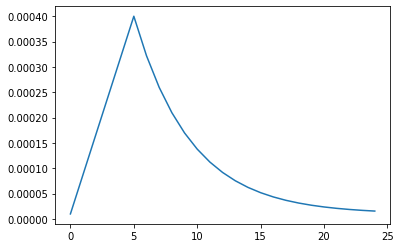

In [5]:
EPOCHS = 12
IMAGE_SIZE = [224, 224]

FLOWERS_DATASETS = { # available image sizes
    192: 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec',
    224: 'gs://flowers-public/tfrecords-jpeg-224x224/*.tfrec',
    331: 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec',
    512: 'gs://flowers-public/tfrecords-jpeg-512x512/*.tfrec'
}
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)
assert IMAGE_SIZE[0] == IMAGE_SIZE[1], "only square images are supported"
assert IMAGE_SIZE[0] in FLOWERS_DATASETS, "this image size is not supported"


# mixed precision
# On TPU, bfloat16/float32 mixed precision is automatically used in TPU computations.
# Enabling it in Keras also stores relevant variables in bfloat16 format (memory optimization).
# On GPU, specifically V100, mixed precision must be enabled for hardware TensorCores to be used.
# XLA compilation must be enabled for this to work. (On TPU, XLA compilation is the default)
MIXED_PRECISION = False
if MIXED_PRECISION:
    if tpu: 
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: #
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
        tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')

# batch and learning rate settings
if strategy.num_replicas_in_sync == 8: # TPU or 8xGPU
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    max_lr = 0.00005 * strategy.num_replicas_in_sync
    min_lr = 0.00001
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
elif strategy.num_replicas_in_sync == 1: # single GPU
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8

def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
rng = [i for i in range(25)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [0]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.unbatch().batch(N)
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;  
  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  #ax.set_ylim(0.28,1.05)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [7]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

gcs_pattern = FLOWERS_DATASETS[IMAGE_SIZE[0]]
validation_split = 0.19
filenames = tf.io.gfile.glob(gcs_pattern)
split = len(filenames) - int(len(filenames) * validation_split)
TRAIN_FILENAMES = filenames[:split]
VALID_FILENAMES = filenames[split:]
TRAIN_STEPS = count_data_items(TRAIN_FILENAMES) // BATCH_SIZE
print("TRAINING IMAGES: ", count_data_items(TRAIN_FILENAMES), ", STEPS PER EPOCH: ", TRAIN_STEPS)
print("VALIDATION IMAGES: ", count_data_items(VALID_FILENAMES))
        
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    class_label = tf.cast(example['class'], tf.int32)
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class
    
def force_image_sizes(dataset, image_size):
    # explicit size will be needed for TPU
    reshape_images = lambda image, label: (tf.reshape(image, [*image_size, 3]), label)
    dataset = dataset.map(reshape_images, num_parallel_calls=AUTO)
    return dataset

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
    # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    opt = tf.data.Options()
    opt.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.with_options(opt)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    dataset = force_image_sizes(dataset, IMAGE_SIZE)
    return dataset

def data_augment(image, one_hot_class):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, one_hot_class
    
# For experts: fine adjustments of tf.data.Dataset distribution behavior:

# Replicating a datset with state (even random number generator state) does not replicate the
# state and changes the behavior of the dataset. If the state is just the RNG state, it usually
# does not matter but this behavior can be adjusted with tf.data.experimental.ExternalStatePolicy:
#  WARN = 0   (this is the default in Tensorflow outside of Keras)
#  IGNORE = 1 (this is the default in Keras)
#  FAIL = 2

# On TPU pods, the dataset API attempts to shard the dataset across individual TPUs at the file
# level so that TPUs only load the data they will actually train on. This requires more data files 
# than TPUs in the pod. (ex: TPU v3-32 pod = 4 TPUs => dataset must have at least 4 files)
# An error will occur if there are not enough data files. File-level sharding can be disabled:
#  opt = tf.data.Options()
#  opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
#  dataset = dataset.with_options(opt)
   

def get_training_dataset():
    dataset = load_dataset(TRAIN_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALID_FILENAMES)
    dataset = dataset.batch(VALIDATION_BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    
    # needed for TPU 32-core pod: the test dataset has only 3 files but there are 4 TPUs. FILE sharding policy must be disabled.
    opt = tf.data.Options()
    opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    dataset = dataset.with_options(opt)
    
    return dataset


TRAINING IMAGES:  2990 , STEPS PER EPOCH:  23
VALIDATION IMAGES:  680


## training and validation datasets

In [0]:
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

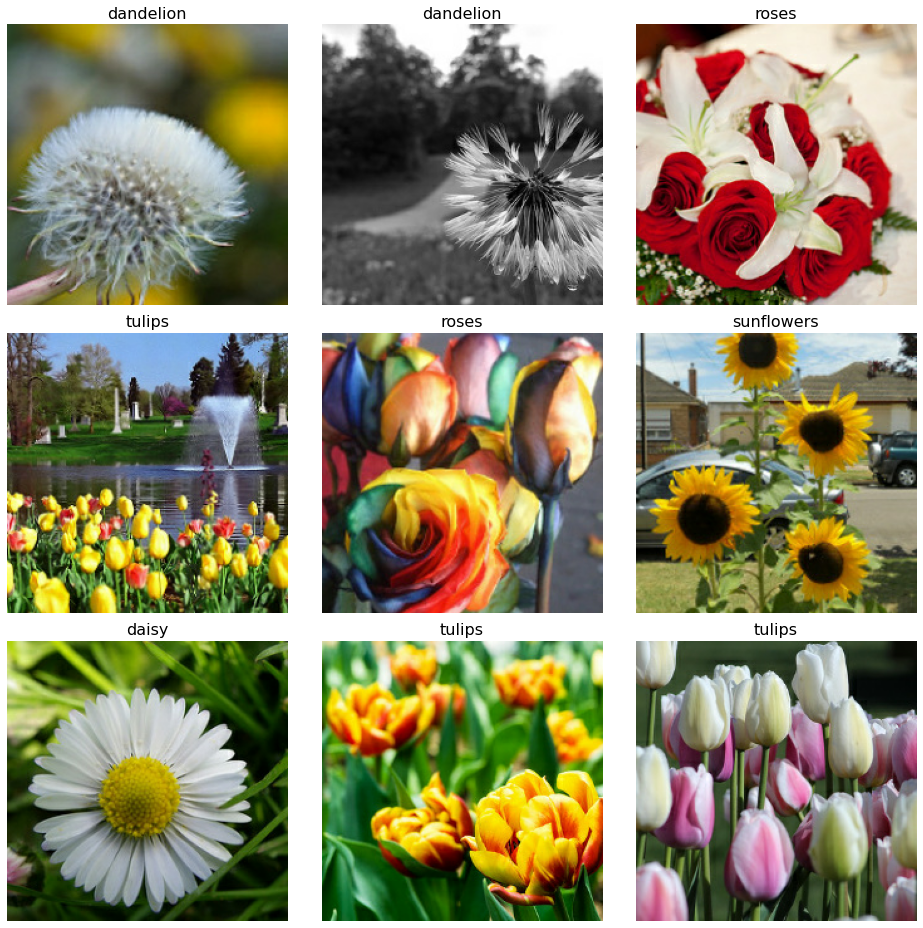

In [9]:
display_9_images_from_dataset(validation_dataset)

## Model

In [0]:
import tensorflow_addons as tfa

In [0]:
class Generalized_mean_pooling2D(tf.keras.layers.Layer):
    def __init__(self, p=3, epsilon=1e-6, name='', **kwargs):
        super(Generalized_mean_pooling2D, self).__init__(name, **kwargs)
        self.init_p = p
        self.epsilon = epsilon
    
    def build(self, input_shape):
        if isinstance(input_shape, list) or len(input_shape) != 4:
            raise ValueError('`GeM` pooling layer only allow 1 input with 4 dimensions(b, h, w, c)')
        self.build_shape = input_shape
        self.p = self.add_weight(name='p',
                                 shape=[1,],
                                 initializer=tf.keras.initializers.Constant(value=self.init_p),
                                 regularizer=None,
                                 trainable=True,
                                 dtype=tf.float32
                                )
        self.built=True
    def call(self, inputs):
        input_shape = inputs.get_shape()
        if isinstance(inputs, list) or len(input_shape) != 4:
            raise ValueError('`GeM` pooling layer only allow 1 input with 4 dimensions(b, h, w, c)')
        return (tf.reduce_mean(tf.abs(inputs**self.p), axis=[1,2], keepdims=False) + self.epsilon)**(1.0/self.p)

def create_model(i_model):
    weight_decay = 1e-4
    if i_model>=1 and i_model<=15:
      if i_model == 1: pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
      elif i_model == 2: pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
      elif i_model == 3: pretrained_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
      elif i_model == 4: pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
      elif i_model == 5: pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
      elif i_model == 6: pretrained_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
      elif i_model == 7: pretrained_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
      elif i_model == 8: pretrained_model = efn.EfficientNetB7(include_top=False, weights='noisy-student',input_shape=[*IMAGE_SIZE,3])
      elif i_model == 9: pretrained_model = efn.EfficientNetB6(include_top=False, weights='noisy-student',input_shape=[*IMAGE_SIZE,3])
      elif i_model == 10: pretrained_model = efn.EfficientNetB5(include_top=False, weights='noisy-student',input_shape=[*IMAGE_SIZE,3])
      elif i_model == 11: pretrained_model = efn.EfficientNetB4(include_top=False, weights='noisy-student',input_shape=[*IMAGE_SIZE,3])
      elif i_model == 12: pretrained_model = efn.EfficientNetB3(include_top=False, weights='noisy-student',input_shape=[*IMAGE_SIZE,3])
      elif i_model == 13: pretrained_model = efn.EfficientNetB2(include_top=False, weights='noisy-student',input_shape=[*IMAGE_SIZE,3])
      elif i_model == 14: pretrained_model = efn.EfficientNetB1(include_top=False, weights='noisy-student',input_shape=[*IMAGE_SIZE,3])
      elif i_model == 15: pretrained_model = efn.EfficientNetB0(include_top=False, weights='noisy-student',input_shape=[*IMAGE_SIZE,3])

    if i_model <= 7: pretrained_model.trainable = False 
    else: pretrained_model.trainable = True
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(512, kernel_initializer='he_normal', activation='elu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(256,kernel_initializer='he_normal',activation='elu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation='softmax', dtype=tf.float32) 
    ])
    
    model.compile(
        optimizer="adam",
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [0]:
def return_model(i_model):
  with strategy.scope(): # creating the model in the TPUStrategy scope places the model on the TPU
      model = create_model(i_model)
  return model

## Training

In [0]:
import os
def get_callbacks(model):
  if not os.path.exists(str(model)+"_callback_output"):
    os.mkdir(str(model)+"_callback_output")
  
  lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
  tqdm_callback = tfa.callbacks.TQDMProgressBar()
  checkpoint = tf.keras.callbacks.ModelCheckpoint(str(model)+"_callback_output" + '/best.h5', 
                              monitor = 'val_loss', 
                              verbose = True, save_best_only=True, 
                              mode = 'min',
                              save_weights_only = True)
  csv_logger = tf.keras.callbacks.CSVLogger(str(model)+"_callback_output" + '/log.csv')
  early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5,verbose=True)
  return [lr_callback, checkpoint, early, tqdm_callback, csv_logger]

In [0]:
import gc
gc.enable()

In [15]:
model_histories = []
finetuned_histories = []
finetuned_models = []
train_models = []
for i_model in range(8,16):
  tf.tpu.experimental.initialize_tpu_system(tpu)

  print(); print("#"*100)
  print("... TRAINING MODEL ... :",i_model)
  print("#"*100)
  start_time = time.time()
  model = return_model(i_model)
  callbacks = get_callbacks(i_model)
  if i_model <=7:
    history = model.fit(training_dataset, validation_data=validation_dataset,
                        steps_per_epoch=TRAIN_STEPS, epochs=15, callbacks=callbacks, verbose=0)
    train_models.append(model)
    model_histories.append(history)

    # Finetuning 70% after 60% of the layers
    limit = int(len(model.layers[0].layers)*0.60)
    print("Finetuning layers at: {}/{}".format(limit, len(model.layers[0].layers)))
    model.trainable = True
    for i in range(0, limit): model.layers[0].layers[i].trainable = False
    for i in range(limit, len(model.layers[0].layers)): model.layers[0].layers[i].trainable = True
    with strategy.scope():
      model.compile(
            optimizer="adam",
            loss = 'categorical_crossentropy',
            metrics=['accuracy']
        )
    history = model.fit(training_dataset, validation_data=validation_dataset,
                        steps_per_epoch=TRAIN_STEPS, epochs=30, initial_epoch=15, callbacks=callbacks, verbose=0)
    finetuned_models.append(model)
    finetuned_histories.append(history)
    final_accuracy = history.history["val_accuracy"][-5:]
    print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
    print("TRAINING TIME: ", time.time() - start_time, " sec")
  else:
    history = model.fit(training_dataset, validation_data=validation_dataset,
                        steps_per_epoch=TRAIN_STEPS, epochs=30, callbacks=callbacks, verbose=0)
    train_models.append(model)
    model_histories.append(history)
    final_accuracy = history.history["val_accuracy"][-5:]
    print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
    print("TRAINING TIME: ", time.time() - start_time, " sec")
  del model, history, callbacks
  gc.collect()

INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



####################################################################################################
... TRAINING MODEL ... : 8
####################################################################################################
258072576/258068648 [==============================] - 4s 0us/step



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30



Epoch 00001: val_loss improved from inf to 1.58748, saving model to 8_callback_output/best.h5


Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30



Epoch 00002: val_loss improved from 1.58748 to 1.03379, saving model to 8_callback_output/best.h5


Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30



Epoch 00003: val_loss improved from 1.03379 to 0.37935, saving model to 8_callback_output/best.h5


Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/30



Epoch 00004: val_loss improved from 0.37935 to 0.23421, saving model to 8_callback_output/best.h5


Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/30



Epoch 00005: val_loss did not improve from 0.23421


Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/30



Epoch 00006: val_loss did not improve from 0.23421


Epoch 00007: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 7/30



Epoch 00007: val_loss improved from 0.23421 to 0.18199, saving model to 8_callback_output/best.h5


Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002596000000000001.
Epoch 8/30



Epoch 00008: val_loss improved from 0.18199 to 0.17893, saving model to 8_callback_output/best.h5


Epoch 00009: LearningRateScheduler reducing learning rate to 0.00020968000000000004.
Epoch 9/30



Epoch 00009: val_loss improved from 0.17893 to 0.16078, saving model to 8_callback_output/best.h5


Epoch 00010: LearningRateScheduler reducing learning rate to 0.00016974400000000002.
Epoch 10/30



Epoch 00010: val_loss improved from 0.16078 to 0.14585, saving model to 8_callback_output/best.h5


Epoch 00011: LearningRateScheduler reducing learning rate to 0.00013779520000000003.
Epoch 11/30



Epoch 00011: val_loss did not improve from 0.14585


Epoch 00012: LearningRateScheduler reducing learning rate to 0.00011223616000000004.
Epoch 12/30



Epoch 00012: val_loss improved from 0.14585 to 0.14371, saving model to 8_callback_output/best.h5


Epoch 00013: LearningRateScheduler reducing learning rate to 9.178892800000003e-05.
Epoch 13/30



Epoch 00013: val_loss improved from 0.14371 to 0.13352, saving model to 8_callback_output/best.h5


Epoch 00014: LearningRateScheduler reducing learning rate to 7.543114240000003e-05.
Epoch 14/30



Epoch 00014: val_loss improved from 0.13352 to 0.13300, saving model to 8_callback_output/best.h5


Epoch 00015: LearningRateScheduler reducing learning rate to 6.234491392000002e-05.
Epoch 15/30



Epoch 00015: val_loss improved from 0.13300 to 0.12780, saving model to 8_callback_output/best.h5


Epoch 00016: LearningRateScheduler reducing learning rate to 5.1875931136000024e-05.
Epoch 16/30



Epoch 00016: val_loss improved from 0.12780 to 0.12726, saving model to 8_callback_output/best.h5


Epoch 00017: LearningRateScheduler reducing learning rate to 4.3500744908800015e-05.
Epoch 17/30



Epoch 00017: val_loss improved from 0.12726 to 0.12559, saving model to 8_callback_output/best.h5


Epoch 00018: LearningRateScheduler reducing learning rate to 3.6800595927040014e-05.
Epoch 18/30



Epoch 00018: val_loss improved from 0.12559 to 0.12280, saving model to 8_callback_output/best.h5


Epoch 00019: LearningRateScheduler reducing learning rate to 3.1440476741632015e-05.
Epoch 19/30



Epoch 00019: val_loss improved from 0.12280 to 0.12104, saving model to 8_callback_output/best.h5


Epoch 00020: LearningRateScheduler reducing learning rate to 2.7152381393305616e-05.
Epoch 20/30



Epoch 00020: val_loss did not improve from 0.12104


Epoch 00021: LearningRateScheduler reducing learning rate to 2.3721905114644494e-05.
Epoch 21/30



Epoch 00021: val_loss improved from 0.12104 to 0.12104, saving model to 8_callback_output/best.h5


Epoch 00022: LearningRateScheduler reducing learning rate to 2.0977524091715595e-05.
Epoch 22/30



Epoch 00022: val_loss improved from 0.12104 to 0.12068, saving model to 8_callback_output/best.h5


Epoch 00023: LearningRateScheduler reducing learning rate to 1.8782019273372477e-05.
Epoch 23/30



Epoch 00023: val_loss did not improve from 0.12068


Epoch 00024: LearningRateScheduler reducing learning rate to 1.702561541869798e-05.
Epoch 24/30



Epoch 00024: val_loss did not improve from 0.12068


Epoch 00025: LearningRateScheduler reducing learning rate to 1.5620492334958385e-05.
Epoch 25/30



Epoch 00025: val_loss improved from 0.12068 to 0.12064, saving model to 8_callback_output/best.h5


Epoch 00026: LearningRateScheduler reducing learning rate to 1.4496393867966709e-05.
Epoch 26/30



Epoch 00026: val_loss did not improve from 0.12064


Epoch 00027: LearningRateScheduler reducing learning rate to 1.3597115094373368e-05.
Epoch 27/30



Epoch 00027: val_loss did not improve from 0.12064


Epoch 00028: LearningRateScheduler reducing learning rate to 1.2877692075498695e-05.
Epoch 28/30



Epoch 00028: val_loss did not improve from 0.12064


Epoch 00029: LearningRateScheduler reducing learning rate to 1.2302153660398955e-05.
Epoch 29/30



Epoch 00029: val_loss did not improve from 0.12064


Epoch 00030: LearningRateScheduler reducing learning rate to 1.1841722928319164e-05.
Epoch 30/30



Epoch 00030: val_loss did not improve from 0.12064

Epoch 00030: early stopping

FINAL ACCURACY MEAN-5:  0.9708823680877685
TRAINING TIME:  1116.9353914260864  sec


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



####################################################################################################
... TRAINING MODEL ... : 9
####################################################################################################
165232640/165226952 [==============================] - 2s 0us/step



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30



Epoch 00001: val_loss improved from inf to 1.59960, saving model to 9_callback_output/best.h5


Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30



Epoch 00002: val_loss improved from 1.59960 to 0.83224, saving model to 9_callback_output/best.h5


Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30



Epoch 00003: val_loss improved from 0.83224 to 0.31838, saving model to 9_callback_output/best.h5


Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/30



Epoch 00004: val_loss improved from 0.31838 to 0.25063, saving model to 9_callback_output/best.h5


Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/30



Epoch 00005: val_loss improved from 0.25063 to 0.23682, saving model to 9_callback_output/best.h5


Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/30



Epoch 00006: val_loss improved from 0.23682 to 0.20851, saving model to 9_callback_output/best.h5


Epoch 00007: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 7/30



Epoch 00007: val_loss improved from 0.20851 to 0.19086, saving model to 9_callback_output/best.h5


Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002596000000000001.
Epoch 8/30



Epoch 00008: val_loss did not improve from 0.19086


Epoch 00009: LearningRateScheduler reducing learning rate to 0.00020968000000000004.
Epoch 9/30



Epoch 00009: val_loss did not improve from 0.19086


Epoch 00010: LearningRateScheduler reducing learning rate to 0.00016974400000000002.
Epoch 10/30



Epoch 00010: val_loss did not improve from 0.19086


Epoch 00011: LearningRateScheduler reducing learning rate to 0.00013779520000000003.
Epoch 11/30



Epoch 00011: val_loss did not improve from 0.19086


Epoch 00012: LearningRateScheduler reducing learning rate to 0.00011223616000000004.
Epoch 12/30



Epoch 00012: val_loss did not improve from 0.19086

Epoch 00012: early stopping

FINAL ACCURACY MEAN-5:  0.9376470923423768
TRAINING TIME:  525.2559731006622  sec


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



####################################################################################################
... TRAINING MODEL ... : 10
####################################################################################################
115261440/115255328 [==============================] - 2s 0us/step



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30



Epoch 00001: val_loss improved from inf to 1.55988, saving model to 10_callback_output/best.h5


Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30



Epoch 00002: val_loss improved from 1.55988 to 0.70635, saving model to 10_callback_output/best.h5


Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30



Epoch 00003: val_loss improved from 0.70635 to 0.23807, saving model to 10_callback_output/best.h5


Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/30



Epoch 00004: val_loss improved from 0.23807 to 0.18500, saving model to 10_callback_output/best.h5


Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/30



Epoch 00005: val_loss improved from 0.18500 to 0.15087, saving model to 10_callback_output/best.h5


Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/30



Epoch 00006: val_loss improved from 0.15087 to 0.14123, saving model to 10_callback_output/best.h5


Epoch 00007: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 7/30



Epoch 00007: val_loss did not improve from 0.14123


Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002596000000000001.
Epoch 8/30



Epoch 00008: val_loss did not improve from 0.14123


Epoch 00009: LearningRateScheduler reducing learning rate to 0.00020968000000000004.
Epoch 9/30



Epoch 00009: val_loss did not improve from 0.14123


Epoch 00010: LearningRateScheduler reducing learning rate to 0.00016974400000000002.
Epoch 10/30



Epoch 00010: val_loss did not improve from 0.14123


Epoch 00011: LearningRateScheduler reducing learning rate to 0.00013779520000000003.
Epoch 11/30



Epoch 00011: val_loss did not improve from 0.14123

Epoch 00011: early stopping

FINAL ACCURACY MEAN-5:  0.9452941417694092
TRAINING TIME:  443.5841612815857  sec


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



####################################################################################################
... TRAINING MODEL ... : 11
####################################################################################################
71680000/71678424 [==============================] - 1s 0us/step



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30



Epoch 00001: val_loss improved from inf to 1.52441, saving model to 11_callback_output/best.h5


Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30



Epoch 00002: val_loss improved from 1.52441 to 0.73910, saving model to 11_callback_output/best.h5


Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30



Epoch 00003: val_loss improved from 0.73910 to 0.27399, saving model to 11_callback_output/best.h5


Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/30



Epoch 00004: val_loss improved from 0.27399 to 0.18765, saving model to 11_callback_output/best.h5


Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/30



Epoch 00005: val_loss improved from 0.18765 to 0.14433, saving model to 11_callback_output/best.h5


Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/30



Epoch 00006: val_loss did not improve from 0.14433


Epoch 00007: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 7/30



Epoch 00007: val_loss did not improve from 0.14433


Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002596000000000001.
Epoch 8/30



Epoch 00008: val_loss improved from 0.14433 to 0.13949, saving model to 11_callback_output/best.h5


Epoch 00009: LearningRateScheduler reducing learning rate to 0.00020968000000000004.
Epoch 9/30



Epoch 00009: val_loss improved from 0.13949 to 0.13943, saving model to 11_callback_output/best.h5


Epoch 00010: LearningRateScheduler reducing learning rate to 0.00016974400000000002.
Epoch 10/30



Epoch 00010: val_loss improved from 0.13943 to 0.11139, saving model to 11_callback_output/best.h5


Epoch 00011: LearningRateScheduler reducing learning rate to 0.00013779520000000003.
Epoch 11/30



Epoch 00011: val_loss did not improve from 0.11139


Epoch 00012: LearningRateScheduler reducing learning rate to 0.00011223616000000004.
Epoch 12/30



Epoch 00012: val_loss did not improve from 0.11139


Epoch 00013: LearningRateScheduler reducing learning rate to 9.178892800000003e-05.
Epoch 13/30



Epoch 00013: val_loss improved from 0.11139 to 0.10795, saving model to 11_callback_output/best.h5


Epoch 00014: LearningRateScheduler reducing learning rate to 7.543114240000003e-05.
Epoch 14/30



Epoch 00014: val_loss improved from 0.10795 to 0.10158, saving model to 11_callback_output/best.h5


Epoch 00015: LearningRateScheduler reducing learning rate to 6.234491392000002e-05.
Epoch 15/30



Epoch 00015: val_loss did not improve from 0.10158


Epoch 00016: LearningRateScheduler reducing learning rate to 5.1875931136000024e-05.
Epoch 16/30



Epoch 00016: val_loss did not improve from 0.10158


Epoch 00017: LearningRateScheduler reducing learning rate to 4.3500744908800015e-05.
Epoch 17/30



Epoch 00017: val_loss did not improve from 0.10158


Epoch 00018: LearningRateScheduler reducing learning rate to 3.6800595927040014e-05.
Epoch 18/30



Epoch 00018: val_loss did not improve from 0.10158


Epoch 00019: LearningRateScheduler reducing learning rate to 3.1440476741632015e-05.
Epoch 19/30



Epoch 00019: val_loss did not improve from 0.10158

Epoch 00019: early stopping

FINAL ACCURACY MEAN-5:  0.9629412055015564
TRAINING TIME:  492.28159499168396  sec


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



####################################################################################################
... TRAINING MODEL ... : 12
####################################################################################################
43933696/43933088 [==============================] - 1s 0us/step



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30



Epoch 00001: val_loss improved from inf to 1.49924, saving model to 12_callback_output/best.h5


Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30



Epoch 00002: val_loss improved from 1.49924 to 0.77023, saving model to 12_callback_output/best.h5


Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30



Epoch 00003: val_loss improved from 0.77023 to 0.26597, saving model to 12_callback_output/best.h5


Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/30



Epoch 00004: val_loss improved from 0.26597 to 0.17462, saving model to 12_callback_output/best.h5


Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/30



Epoch 00005: val_loss improved from 0.17462 to 0.14812, saving model to 12_callback_output/best.h5


Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/30



Epoch 00006: val_loss improved from 0.14812 to 0.13666, saving model to 12_callback_output/best.h5


Epoch 00007: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 7/30



Epoch 00007: val_loss did not improve from 0.13666


Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002596000000000001.
Epoch 8/30



Epoch 00008: val_loss improved from 0.13666 to 0.12150, saving model to 12_callback_output/best.h5


Epoch 00009: LearningRateScheduler reducing learning rate to 0.00020968000000000004.
Epoch 9/30



Epoch 00009: val_loss did not improve from 0.12150


Epoch 00010: LearningRateScheduler reducing learning rate to 0.00016974400000000002.
Epoch 10/30



Epoch 00010: val_loss improved from 0.12150 to 0.11946, saving model to 12_callback_output/best.h5


Epoch 00011: LearningRateScheduler reducing learning rate to 0.00013779520000000003.
Epoch 11/30



Epoch 00011: val_loss improved from 0.11946 to 0.11062, saving model to 12_callback_output/best.h5


Epoch 00012: LearningRateScheduler reducing learning rate to 0.00011223616000000004.
Epoch 12/30



Epoch 00012: val_loss improved from 0.11062 to 0.10981, saving model to 12_callback_output/best.h5


Epoch 00013: LearningRateScheduler reducing learning rate to 9.178892800000003e-05.
Epoch 13/30



Epoch 00013: val_loss did not improve from 0.10981


Epoch 00014: LearningRateScheduler reducing learning rate to 7.543114240000003e-05.
Epoch 14/30



Epoch 00014: val_loss improved from 0.10981 to 0.10035, saving model to 12_callback_output/best.h5


Epoch 00015: LearningRateScheduler reducing learning rate to 6.234491392000002e-05.
Epoch 15/30



Epoch 00015: val_loss did not improve from 0.10035


Epoch 00016: LearningRateScheduler reducing learning rate to 5.1875931136000024e-05.
Epoch 16/30



Epoch 00016: val_loss improved from 0.10035 to 0.09399, saving model to 12_callback_output/best.h5


Epoch 00017: LearningRateScheduler reducing learning rate to 4.3500744908800015e-05.
Epoch 17/30



Epoch 00017: val_loss improved from 0.09399 to 0.08713, saving model to 12_callback_output/best.h5


Epoch 00018: LearningRateScheduler reducing learning rate to 3.6800595927040014e-05.
Epoch 18/30



Epoch 00018: val_loss did not improve from 0.08713


Epoch 00019: LearningRateScheduler reducing learning rate to 3.1440476741632015e-05.
Epoch 19/30



Epoch 00019: val_loss did not improve from 0.08713


Epoch 00020: LearningRateScheduler reducing learning rate to 2.7152381393305616e-05.
Epoch 20/30



Epoch 00020: val_loss did not improve from 0.08713


Epoch 00021: LearningRateScheduler reducing learning rate to 2.3721905114644494e-05.
Epoch 21/30



Epoch 00021: val_loss did not improve from 0.08713


Epoch 00022: LearningRateScheduler reducing learning rate to 2.0977524091715595e-05.
Epoch 22/30



Epoch 00022: val_loss did not improve from 0.08713

Epoch 00022: early stopping

FINAL ACCURACY MEAN-5:  0.9705882549285889
TRAINING TIME:  436.77030634880066  sec


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



####################################################################################################
... TRAINING MODEL ... : 13
####################################################################################################
31784960/31782304 [==============================] - 1s 0us/step



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30



Epoch 00001: val_loss improved from inf to 1.64227, saving model to 13_callback_output/best.h5


Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30



Epoch 00002: val_loss improved from 1.64227 to 0.90807, saving model to 13_callback_output/best.h5


Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30



Epoch 00003: val_loss improved from 0.90807 to 0.34280, saving model to 13_callback_output/best.h5


Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/30



Epoch 00004: val_loss improved from 0.34280 to 0.22934, saving model to 13_callback_output/best.h5


Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/30



Epoch 00005: val_loss improved from 0.22934 to 0.20033, saving model to 13_callback_output/best.h5


Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/30



Epoch 00006: val_loss improved from 0.20033 to 0.15834, saving model to 13_callback_output/best.h5


Epoch 00007: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 7/30



Epoch 00007: val_loss did not improve from 0.15834


Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002596000000000001.
Epoch 8/30



Epoch 00008: val_loss improved from 0.15834 to 0.15065, saving model to 13_callback_output/best.h5


Epoch 00009: LearningRateScheduler reducing learning rate to 0.00020968000000000004.
Epoch 9/30



Epoch 00009: val_loss improved from 0.15065 to 0.14798, saving model to 13_callback_output/best.h5


Epoch 00010: LearningRateScheduler reducing learning rate to 0.00016974400000000002.
Epoch 10/30



Epoch 00010: val_loss did not improve from 0.14798


Epoch 00011: LearningRateScheduler reducing learning rate to 0.00013779520000000003.
Epoch 11/30



Epoch 00011: val_loss improved from 0.14798 to 0.14341, saving model to 13_callback_output/best.h5


Epoch 00012: LearningRateScheduler reducing learning rate to 0.00011223616000000004.
Epoch 12/30



Epoch 00012: val_loss improved from 0.14341 to 0.12811, saving model to 13_callback_output/best.h5


Epoch 00013: LearningRateScheduler reducing learning rate to 9.178892800000003e-05.
Epoch 13/30



Epoch 00013: val_loss improved from 0.12811 to 0.12527, saving model to 13_callback_output/best.h5


Epoch 00014: LearningRateScheduler reducing learning rate to 7.543114240000003e-05.
Epoch 14/30



Epoch 00014: val_loss did not improve from 0.12527


Epoch 00015: LearningRateScheduler reducing learning rate to 6.234491392000002e-05.
Epoch 15/30



Epoch 00015: val_loss improved from 0.12527 to 0.12504, saving model to 13_callback_output/best.h5


Epoch 00016: LearningRateScheduler reducing learning rate to 5.1875931136000024e-05.
Epoch 16/30



Epoch 00016: val_loss improved from 0.12504 to 0.11381, saving model to 13_callback_output/best.h5


Epoch 00017: LearningRateScheduler reducing learning rate to 4.3500744908800015e-05.
Epoch 17/30



Epoch 00017: val_loss improved from 0.11381 to 0.11241, saving model to 13_callback_output/best.h5


Epoch 00018: LearningRateScheduler reducing learning rate to 3.6800595927040014e-05.
Epoch 18/30



Epoch 00018: val_loss did not improve from 0.11241


Epoch 00019: LearningRateScheduler reducing learning rate to 3.1440476741632015e-05.
Epoch 19/30



Epoch 00019: val_loss improved from 0.11241 to 0.10780, saving model to 13_callback_output/best.h5


Epoch 00020: LearningRateScheduler reducing learning rate to 2.7152381393305616e-05.
Epoch 20/30



Epoch 00020: val_loss improved from 0.10780 to 0.10456, saving model to 13_callback_output/best.h5


Epoch 00021: LearningRateScheduler reducing learning rate to 2.3721905114644494e-05.
Epoch 21/30



Epoch 00021: val_loss improved from 0.10456 to 0.10354, saving model to 13_callback_output/best.h5


Epoch 00022: LearningRateScheduler reducing learning rate to 2.0977524091715595e-05.
Epoch 22/30



Epoch 00022: val_loss improved from 0.10354 to 0.10209, saving model to 13_callback_output/best.h5


Epoch 00023: LearningRateScheduler reducing learning rate to 1.8782019273372477e-05.
Epoch 23/30



Epoch 00023: val_loss improved from 0.10209 to 0.10100, saving model to 13_callback_output/best.h5


Epoch 00024: LearningRateScheduler reducing learning rate to 1.702561541869798e-05.
Epoch 24/30



Epoch 00024: val_loss improved from 0.10100 to 0.09915, saving model to 13_callback_output/best.h5


Epoch 00025: LearningRateScheduler reducing learning rate to 1.5620492334958385e-05.
Epoch 25/30



Epoch 00025: val_loss improved from 0.09915 to 0.09773, saving model to 13_callback_output/best.h5


Epoch 00026: LearningRateScheduler reducing learning rate to 1.4496393867966709e-05.
Epoch 26/30



Epoch 00026: val_loss did not improve from 0.09773


Epoch 00027: LearningRateScheduler reducing learning rate to 1.3597115094373368e-05.
Epoch 27/30



Epoch 00027: val_loss did not improve from 0.09773


Epoch 00028: LearningRateScheduler reducing learning rate to 1.2877692075498695e-05.
Epoch 28/30



Epoch 00028: val_loss did not improve from 0.09773


Epoch 00029: LearningRateScheduler reducing learning rate to 1.2302153660398955e-05.
Epoch 29/30



Epoch 00029: val_loss did not improve from 0.09773


Epoch 00030: LearningRateScheduler reducing learning rate to 1.1841722928319164e-05.
Epoch 30/30



Epoch 00030: val_loss did not improve from 0.09773

Epoch 00030: early stopping

FINAL ACCURACY MEAN-5:  0.9623529791831971
TRAINING TIME:  494.10063338279724  sec


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



####################################################################################################
... TRAINING MODEL ... : 14
####################################################################################################
27017216/27010080 [==============================] - 0s 0us/step



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30



Epoch 00001: val_loss improved from inf to 1.63263, saving model to 14_callback_output/best.h5


Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30



Epoch 00002: val_loss improved from 1.63263 to 0.95124, saving model to 14_callback_output/best.h5


Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30



Epoch 00003: val_loss improved from 0.95124 to 0.35865, saving model to 14_callback_output/best.h5


Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/30



Epoch 00004: val_loss improved from 0.35865 to 0.21437, saving model to 14_callback_output/best.h5


Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/30



Epoch 00005: val_loss improved from 0.21437 to 0.16806, saving model to 14_callback_output/best.h5


Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/30



Epoch 00006: val_loss improved from 0.16806 to 0.13448, saving model to 14_callback_output/best.h5


Epoch 00007: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 7/30



Epoch 00007: val_loss did not improve from 0.13448


Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002596000000000001.
Epoch 8/30



Epoch 00008: val_loss did not improve from 0.13448


Epoch 00009: LearningRateScheduler reducing learning rate to 0.00020968000000000004.
Epoch 9/30



Epoch 00009: val_loss improved from 0.13448 to 0.12706, saving model to 14_callback_output/best.h5


Epoch 00010: LearningRateScheduler reducing learning rate to 0.00016974400000000002.
Epoch 10/30



Epoch 00010: val_loss improved from 0.12706 to 0.12356, saving model to 14_callback_output/best.h5


Epoch 00011: LearningRateScheduler reducing learning rate to 0.00013779520000000003.
Epoch 11/30



Epoch 00011: val_loss improved from 0.12356 to 0.12085, saving model to 14_callback_output/best.h5


Epoch 00012: LearningRateScheduler reducing learning rate to 0.00011223616000000004.
Epoch 12/30



Epoch 00012: val_loss improved from 0.12085 to 0.10470, saving model to 14_callback_output/best.h5


Epoch 00013: LearningRateScheduler reducing learning rate to 9.178892800000003e-05.
Epoch 13/30



Epoch 00013: val_loss did not improve from 0.10470


Epoch 00014: LearningRateScheduler reducing learning rate to 7.543114240000003e-05.
Epoch 14/30



Epoch 00014: val_loss did not improve from 0.10470


Epoch 00015: LearningRateScheduler reducing learning rate to 6.234491392000002e-05.
Epoch 15/30



Epoch 00015: val_loss did not improve from 0.10470


Epoch 00016: LearningRateScheduler reducing learning rate to 5.1875931136000024e-05.
Epoch 16/30



Epoch 00016: val_loss improved from 0.10470 to 0.10333, saving model to 14_callback_output/best.h5


Epoch 00017: LearningRateScheduler reducing learning rate to 4.3500744908800015e-05.
Epoch 17/30



Epoch 00017: val_loss improved from 0.10333 to 0.10058, saving model to 14_callback_output/best.h5


Epoch 00018: LearningRateScheduler reducing learning rate to 3.6800595927040014e-05.
Epoch 18/30



Epoch 00018: val_loss did not improve from 0.10058


Epoch 00019: LearningRateScheduler reducing learning rate to 3.1440476741632015e-05.
Epoch 19/30



Epoch 00019: val_loss improved from 0.10058 to 0.09774, saving model to 14_callback_output/best.h5


Epoch 00020: LearningRateScheduler reducing learning rate to 2.7152381393305616e-05.
Epoch 20/30



Epoch 00020: val_loss improved from 0.09774 to 0.09649, saving model to 14_callback_output/best.h5


Epoch 00021: LearningRateScheduler reducing learning rate to 2.3721905114644494e-05.
Epoch 21/30



Epoch 00021: val_loss improved from 0.09649 to 0.09399, saving model to 14_callback_output/best.h5


Epoch 00022: LearningRateScheduler reducing learning rate to 2.0977524091715595e-05.
Epoch 22/30



Epoch 00022: val_loss improved from 0.09399 to 0.09350, saving model to 14_callback_output/best.h5


Epoch 00023: LearningRateScheduler reducing learning rate to 1.8782019273372477e-05.
Epoch 23/30



Epoch 00023: val_loss did not improve from 0.09350


Epoch 00024: LearningRateScheduler reducing learning rate to 1.702561541869798e-05.
Epoch 24/30



Epoch 00024: val_loss did not improve from 0.09350


Epoch 00025: LearningRateScheduler reducing learning rate to 1.5620492334958385e-05.
Epoch 25/30



Epoch 00025: val_loss did not improve from 0.09350


Epoch 00026: LearningRateScheduler reducing learning rate to 1.4496393867966709e-05.
Epoch 26/30



Epoch 00026: val_loss did not improve from 0.09350


Epoch 00027: LearningRateScheduler reducing learning rate to 1.3597115094373368e-05.
Epoch 27/30



Epoch 00027: val_loss did not improve from 0.09350

Epoch 00027: early stopping

FINAL ACCURACY MEAN-5:  0.9676470756530762
TRAINING TIME:  447.1985659599304  sec


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.25.98.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



####################################################################################################
... TRAINING MODEL ... : 15
####################################################################################################
16703488/16696600 [==============================] - 0s 0us/step



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30



Epoch 00001: val_loss improved from inf to 1.55875, saving model to 15_callback_output/best.h5


Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30



Epoch 00002: val_loss improved from 1.55875 to 0.87738, saving model to 15_callback_output/best.h5


Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30



Epoch 00003: val_loss improved from 0.87738 to 0.33192, saving model to 15_callback_output/best.h5


Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/30



Epoch 00004: val_loss improved from 0.33192 to 0.21662, saving model to 15_callback_output/best.h5


Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/30



Epoch 00005: val_loss did not improve from 0.21662


Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 6/30



Epoch 00006: val_loss did not improve from 0.21662


Epoch 00007: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 7/30



Epoch 00007: val_loss improved from 0.21662 to 0.17668, saving model to 15_callback_output/best.h5


Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002596000000000001.
Epoch 8/30



Epoch 00008: val_loss improved from 0.17668 to 0.14814, saving model to 15_callback_output/best.h5


Epoch 00009: LearningRateScheduler reducing learning rate to 0.00020968000000000004.
Epoch 9/30



Epoch 00009: val_loss improved from 0.14814 to 0.13254, saving model to 15_callback_output/best.h5


Epoch 00010: LearningRateScheduler reducing learning rate to 0.00016974400000000002.
Epoch 10/30



Epoch 00010: val_loss did not improve from 0.13254


Epoch 00011: LearningRateScheduler reducing learning rate to 0.00013779520000000003.
Epoch 11/30



Epoch 00011: val_loss improved from 0.13254 to 0.12940, saving model to 15_callback_output/best.h5


Epoch 00012: LearningRateScheduler reducing learning rate to 0.00011223616000000004.
Epoch 12/30



Epoch 00012: val_loss improved from 0.12940 to 0.12163, saving model to 15_callback_output/best.h5


Epoch 00013: LearningRateScheduler reducing learning rate to 9.178892800000003e-05.
Epoch 13/30



Epoch 00013: val_loss improved from 0.12163 to 0.11644, saving model to 15_callback_output/best.h5


Epoch 00014: LearningRateScheduler reducing learning rate to 7.543114240000003e-05.
Epoch 14/30



Epoch 00014: val_loss improved from 0.11644 to 0.11583, saving model to 15_callback_output/best.h5


Epoch 00015: LearningRateScheduler reducing learning rate to 6.234491392000002e-05.
Epoch 15/30



Epoch 00015: val_loss did not improve from 0.11583


Epoch 00016: LearningRateScheduler reducing learning rate to 5.1875931136000024e-05.
Epoch 16/30



Epoch 00016: val_loss did not improve from 0.11583


Epoch 00017: LearningRateScheduler reducing learning rate to 4.3500744908800015e-05.
Epoch 17/30



Epoch 00017: val_loss did not improve from 0.11583


Epoch 00018: LearningRateScheduler reducing learning rate to 3.6800595927040014e-05.
Epoch 18/30



Epoch 00018: val_loss did not improve from 0.11583


Epoch 00019: LearningRateScheduler reducing learning rate to 3.1440476741632015e-05.
Epoch 19/30



Epoch 00019: val_loss did not improve from 0.11583

Epoch 00019: early stopping

FINAL ACCURACY MEAN-5:  0.9620588541030883
TRAINING TIME:  256.3576922416687  sec


In [16]:
!zip -r ./8results.zip ./8_callback_output/
!zip -r ./9results.zip ./9_callback_output/
!zip -r ./10results.zip ./10_callback_output/
!zip -r ./11results.zip ./11_callback_output/
!zip -r ./12results.zip ./12_callback_output/
!zip -r ./13results.zip ./13_callback_output/
!zip -r ./14results.zip ./14_callback_output/
!zip -r ./15results.zip ./15_callback_output/

  adding: 8_callback_output/ (stored 0%)
  adding: 8_callback_output/best.h5 (deflated 7%)
  adding: 8_callback_output/log.csv (deflated 56%)
  adding: 9_callback_output/ (stored 0%)
  adding: 9_callback_output/best.h5 (deflated 8%)
  adding: 9_callback_output/log.csv (deflated 50%)
  adding: 10_callback_output/ (stored 0%)
  adding: 10_callback_output/best.h5 (deflated 8%)
  adding: 10_callback_output/log.csv (deflated 49%)
  adding: 11_callback_output/ (stored 0%)
  adding: 11_callback_output/best.h5 (deflated 8%)
  adding: 11_callback_output/log.csv (deflated 53%)
  adding: 12_callback_output/ (stored 0%)
  adding: 12_callback_output/best.h5 (deflated 8%)
  adding: 12_callback_output/log.csv (deflated 55%)
  adding: 13_callback_output/ (stored 0%)
  adding: 13_callback_output/best.h5 (deflated 8%)
  adding: 13_callback_output/log.csv (deflated 57%)
  adding: 14_callback_output/ (stored 0%)
  adding: 14_callback_output/best.h5 (deflated 8%)
  adding: 14_callback_output/log.csv (defla

In [0]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [15]:
len(model.layers[0].layers)

806

In [0]:
limit = int(155 * 0.70)

In [16]:
limit = 520
model.trainable = True
for i in range(0, limit): model.layers[0].layers[i].trainable = False
for i in range(limit, 806): model.layers[0].layers[i].trainable = True
with strategy.scope():
  model.compile(
        optimizer="adam",
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )
  model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
generalized_mean_pooling2d ( (None, 2560)              1         
_________________________________________________________________
dense (Dense)                (None, 5)                 12805     
Total params: 64,110,486
Trainable params: 53,066,862
Non-trainable params: 11,043,624
_________________________________________________________________


In [17]:
start_time = time.time()
history = model.fit(training_dataset, 
                    validation_data=validation_dataset,
                    steps_per_epoch=TRAIN_STEPS, 
                    initial_epoch=10, 
                    epochs=25, 
                    callbacks=[lr_callback,tfa.callbacks.tqdm_progress_bar.TQDMProgressBar()], 
                    verbose=0
                    )

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")


Epoch 00011: LearningRateScheduler reducing learning rate to 0.00019158080000000003.
Epoch 11/25




Epoch 00012: LearningRateScheduler reducing learning rate to 0.00017126464000000004.
Epoch 12/25




Epoch 00013: LearningRateScheduler reducing learning rate to 0.000155011712.
Epoch 13/25




Epoch 00014: LearningRateScheduler reducing learning rate to 0.00014200936960000003.
Epoch 14/25




Epoch 00015: LearningRateScheduler reducing learning rate to 0.00013160749568000003.
Epoch 15/25




Epoch 00016: LearningRateScheduler reducing learning rate to 0.00012328599654400004.
Epoch 16/25


KeyboardInterrupt: ignored

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'lr'])


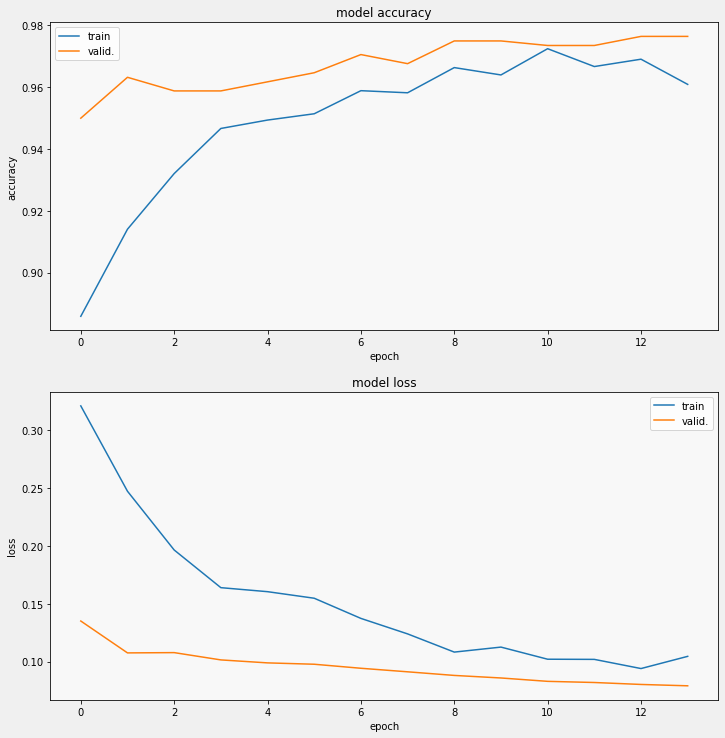

In [19]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

## Predictions

In [0]:
# a couple of images to test predictions too
some_flowers, some_labels = dataset_to_numpy_util(validation_dataset, 160)

160/160 [==============================] - 7s 47ms/sample - loss: 0.0819 - accuracy: 0.9812
['tulips', 'sunflowers', 'sunflowers', 'sunflowers', 'roses', 'tulips', 'dandelion', 'tulips', 'tulips', 'roses', 'daisy', 'dandelion', 'sunflowers', 'roses', 'daisy', 'dandelion', 'dandelion', 'dandelion', 'roses', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'daisy', 'sunflowers', 'dandelion', 'roses', 'dandelion', 'sunflowers', 'roses', 'roses', 'dandelion', 'roses', 'tulips', 'roses', 'dandelion', 'tulips', 'roses', 'sunflowers', 'tulips', 'tulips', 'tulips', 'sunflowers', 'tulips', 'dandelion', 'tulips', 'tulips', 'tulips', 'daisy', 'daisy', 'dandelion', 'sunflowers', 'roses', 'roses', 'dandelion', 'dandelion', 'sunflowers', 'tulips', 'dandelion', 'roses', 'dandelion', 'daisy', 'tulips', 'roses', 'sunflowers', 'sunflowers', 'daisy', 'dandelion', 'daisy', 'daisy', 'roses', 'tulips', 'daisy', 'roses', 'dandelion', 'roses', 'dandelion', 'tulips', 'daisy', 'dandelion'

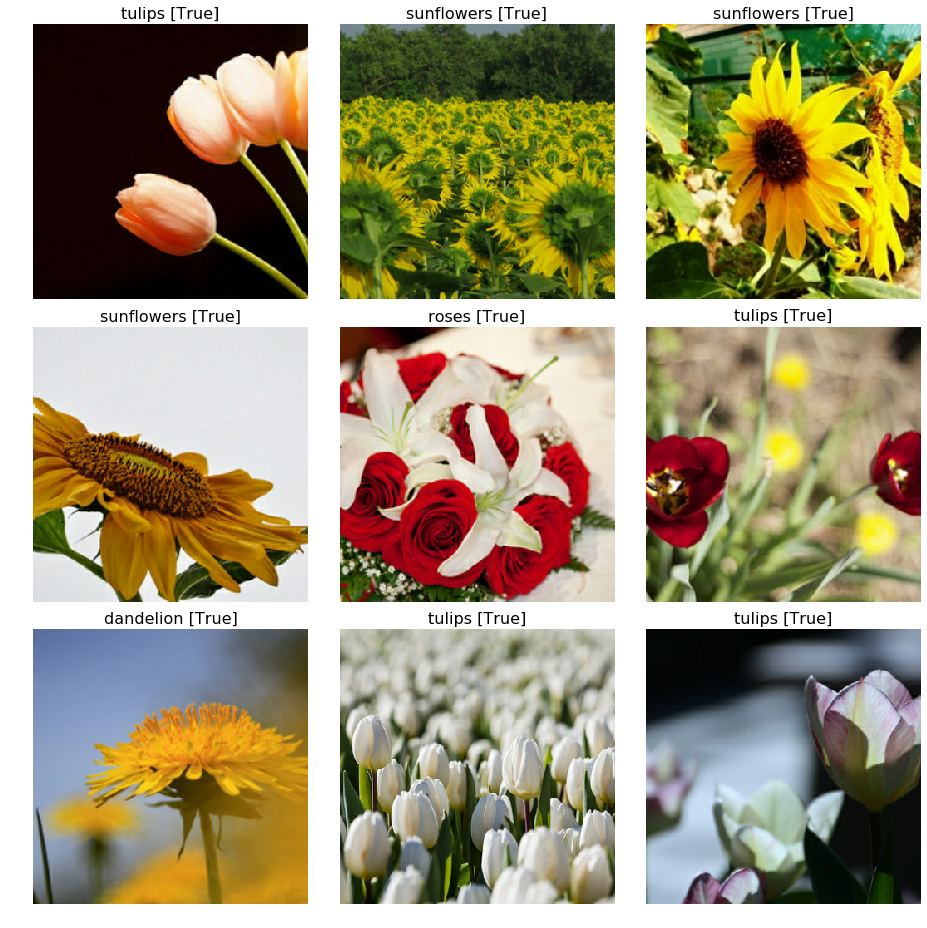

In [0]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

display_9_images_with_predictions(some_flowers, predictions, some_labels)

## Save the model

In [0]:
model.save('model.h5')

## Reload the model

160/160 [==============================] - 7s 47ms/sample - loss: 0.0852 - accuracy: 0.9750
['tulips', 'sunflowers', 'sunflowers', 'sunflowers', 'roses', 'tulips', 'dandelion', 'tulips', 'tulips', 'roses', 'daisy', 'dandelion', 'sunflowers', 'roses', 'daisy', 'dandelion', 'dandelion', 'dandelion', 'roses', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'daisy', 'sunflowers', 'dandelion', 'roses', 'dandelion', 'sunflowers', 'roses', 'roses', 'dandelion', 'roses', 'tulips', 'roses', 'dandelion', 'tulips', 'roses', 'sunflowers', 'tulips', 'tulips', 'tulips', 'sunflowers', 'tulips', 'dandelion', 'tulips', 'tulips', 'tulips', 'daisy', 'daisy', 'dandelion', 'sunflowers', 'roses', 'roses', 'dandelion', 'dandelion', 'sunflowers', 'tulips', 'dandelion', 'roses', 'dandelion', 'daisy', 'tulips', 'roses', 'sunflowers', 'sunflowers', 'daisy', 'dandelion', 'daisy', 'daisy', 'roses', 'tulips', 'daisy', 'roses', 'dandelion', 'roses', 'dandelion', 'tulips', 'daisy', 'dandelion'

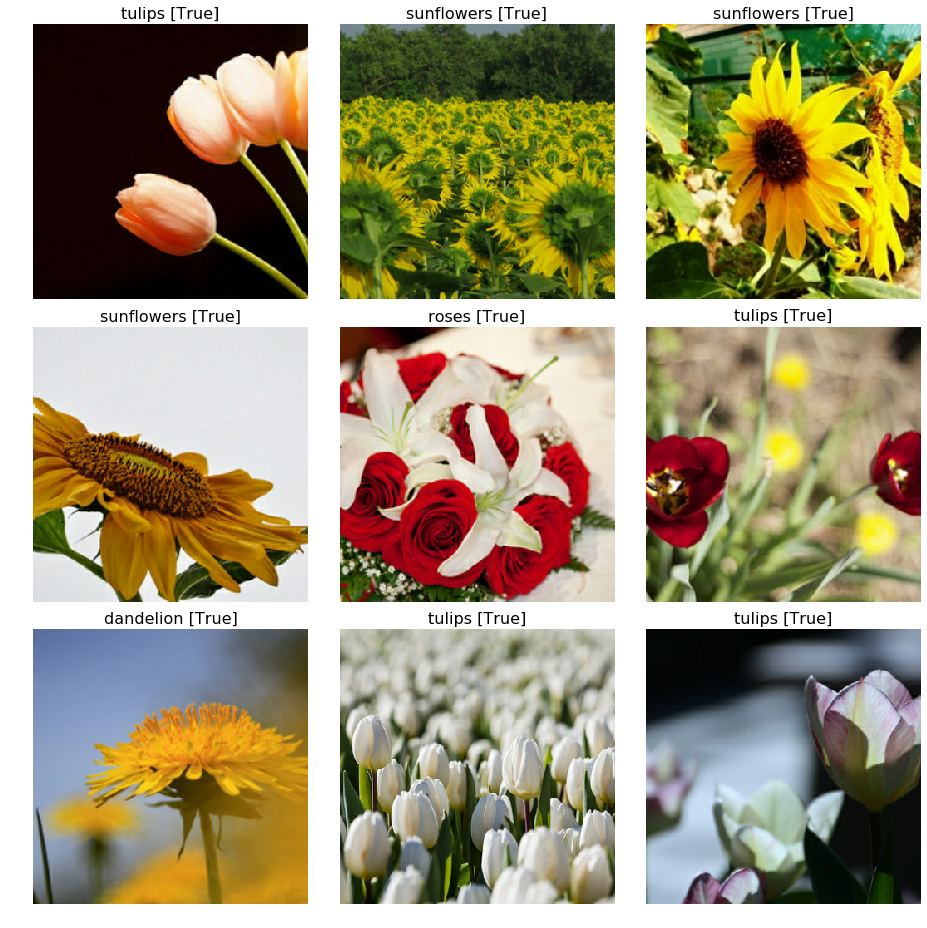

In [0]:
reload_model = tf.keras.models.load_model('model.h5')

predictions = reload_model.predict(some_flowers, batch_size=16)
evaluations = reload_model.evaluate(some_flowers, some_labels, batch_size=16)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)
display_9_images_with_predictions(some_flowers, predictions, some_labels)



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
